In [52]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_theme()

In [53]:
master_data = pd.read_csv('diamonds.csv')
diamonds = master_data.copy()
print(diamonds.shape)
diamonds.head()

(53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [54]:
nan_counts = diamonds.isna().sum()
print(nan_counts)

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64


In [55]:
diamonds_sub = diamonds.drop(['cut','Unnamed: 0'],axis=1)
diamonds_sub.dtypes

carat      float64
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [56]:
categoricals = ['color','clarity']
diamonds_sub[categoricals] = diamonds_sub[categoricals].astype('category')
diamonds_sub.dtypes

carat       float64
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

In [57]:
diamonds_sub.head(1)

,carat,color,clarity,depth,table,price,x,y,z
0,0.23,E,SI2,61.5,55.0,326,3.95,3.98,2.43


In [58]:
diamonds_sub.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### From the above descriptive statistics, there seem to be outliers for all the numerical variables. Let's remove outliers that are far away from the mean by more than 3 standard deviations.

In [59]:
# Separate numerical and categorical columns
numerical_cols = diamonds_sub.select_dtypes(include=np.number).columns
categorical_cols = diamonds_sub.select_dtypes(exclude=np.number).columns

# Calculate mean and standard deviation for numerical columns
means = diamonds_sub[numerical_cols].mean()
stds = diamonds_sub[numerical_cols].std()

# Define a function to remove outliers
def remove_outliers(column):
    return column[(column - 
                   means[column.name]).abs() <= 3 * stds[column.name]]

# Apply the function to each numerical column
diamonds_cleaned = diamonds_sub[numerical_cols].apply(remove_outliers)

# Concatenate with the categorical columns
diamonds_cleaned = pd.concat([diamonds_sub[categorical_cols]
                              , diamonds_cleaned], axis=1)

# Drop rows with any NaN values (if any)
diamonds_cleaned = diamonds_cleaned.dropna()

# Reset index
diamonds_cleaned.reset_index(drop=True, inplace=True)

# Now df_cleaned contains the dataframe with 
# outliers removed from numerical variables
diamonds_cleaned.describe()

,carat,depth,table,price,x,y,z
count,51590.000000,51590.000000,51590.000000,51590.000000,51590.000000,51590.000000,51590.000000
mean,0.759933,61.752838,57.369137,3586.031847,5.657855,5.661272,3.494649
std,0.424983,1.269255,2.100018,3436.874161,1.057420,1.050383,0.653051
min,0.200000,57.500000,51.000000,326.000000,3.730000,3.680000,1.530000
25%,0.390000,61.100000,56.000000,926.000000,4.690000,4.700000,2.890000
50%,0.700000,61.800000,57.000000,2303.500000,5.660000,5.660000,3.490000
75%,1.020000,62.500000,59.000000,5047.000000,6.490000,6.490000,4.010000
max,2.210000,66.000000,64.000000,15898.000000,8.600000,8.550000,5.300000


In [60]:
numericals = diamonds_cleaned[['carat','depth','table','x','y','z']]
categoricals = diamonds_cleaned[['color','clarity']]
price = diamonds_cleaned['price']

## Selection of Regression Predictors

### Once outliers are removed, we can now conduct selection of regression predictors. 

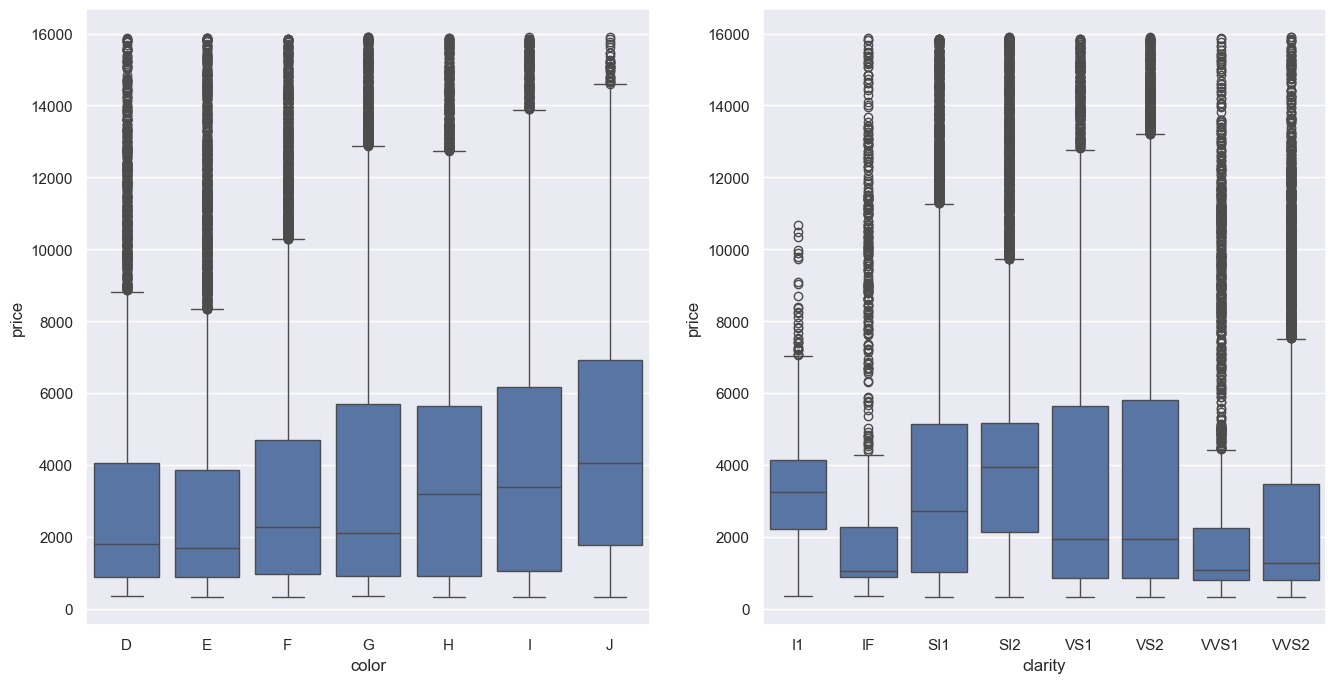

In [61]:
f, axes = plt.subplots(1,2,figsize=(16,8))
x = 0

for cat in categoricals:
    sb.boxplot(data = categoricals,x = cat,y = price,ax = axes[x])
    x += 1

### For variable 'color, there is significant overlap of the interquartile ranges across all 'colors'. The boxplot price distributions get increasingly wider from D to J, indicating that lower grade colour diamonds can be priced higher. This contradicts domain knowledge, but since color is used as a grading criteria of diamonds, it would still be included to account for this relationship.
### For 'clarity', domain knowledge suggests that diamond price should increase from right to left. This is not clear, but it does capture some diamond price variation. Hence, clarity would be included.
### Next, we will single out numerical variables as predictors. Since depth is a function of (x,y,z) in the dataset, if either is included the other would have to be removed.

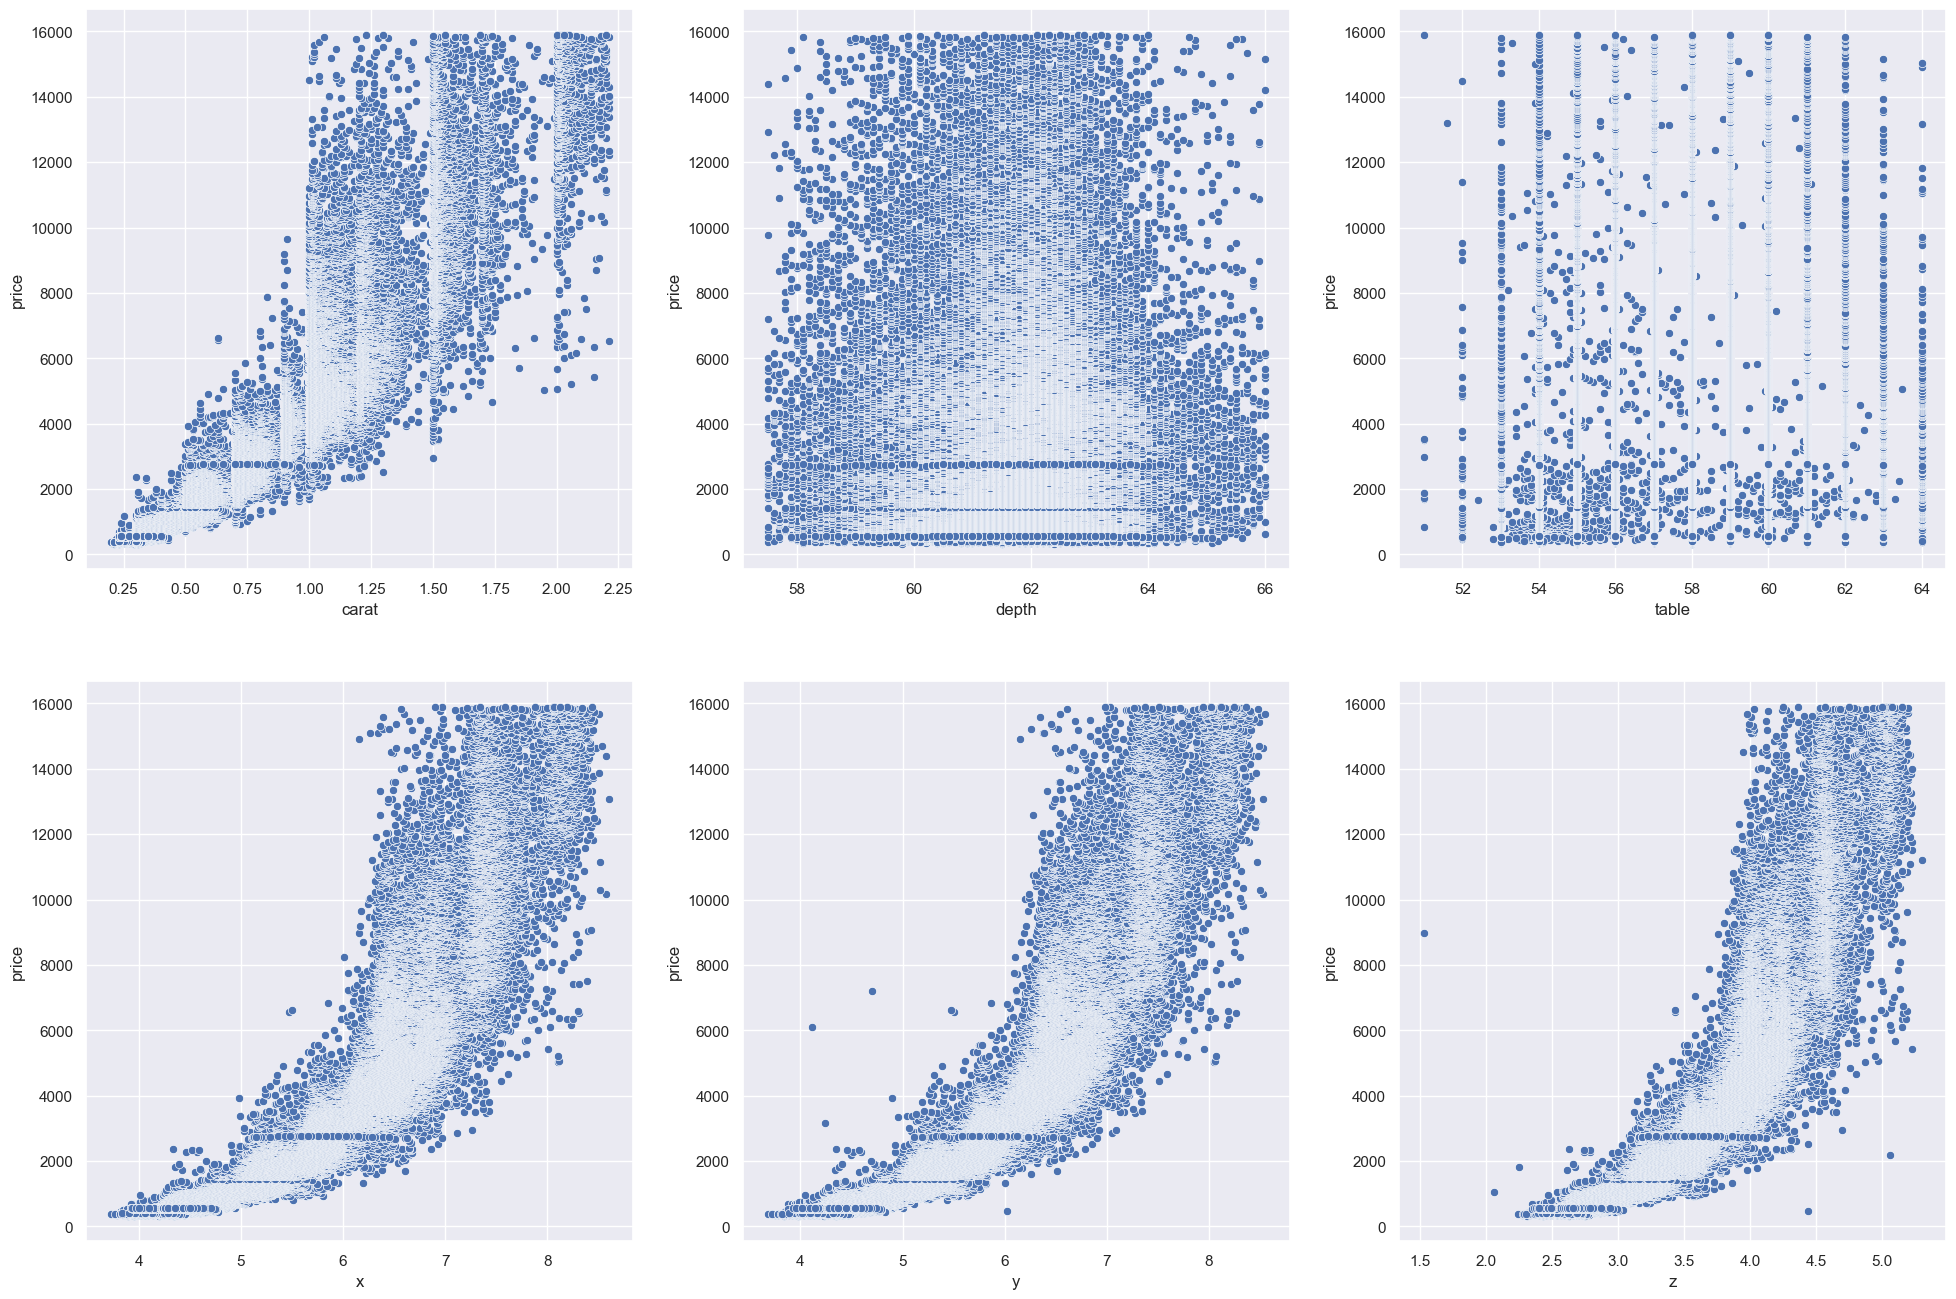

In [62]:
f, axes = plt.subplots(2,3,figsize=(24,16))
r = 0
c = 0

for num in numericals:
    sb.scatterplot(data = numericals,x = num,y = price,ax = axes[r,c])
    c += 1
    if c == 3:
        c = 0
        r += 1

<Axes: >

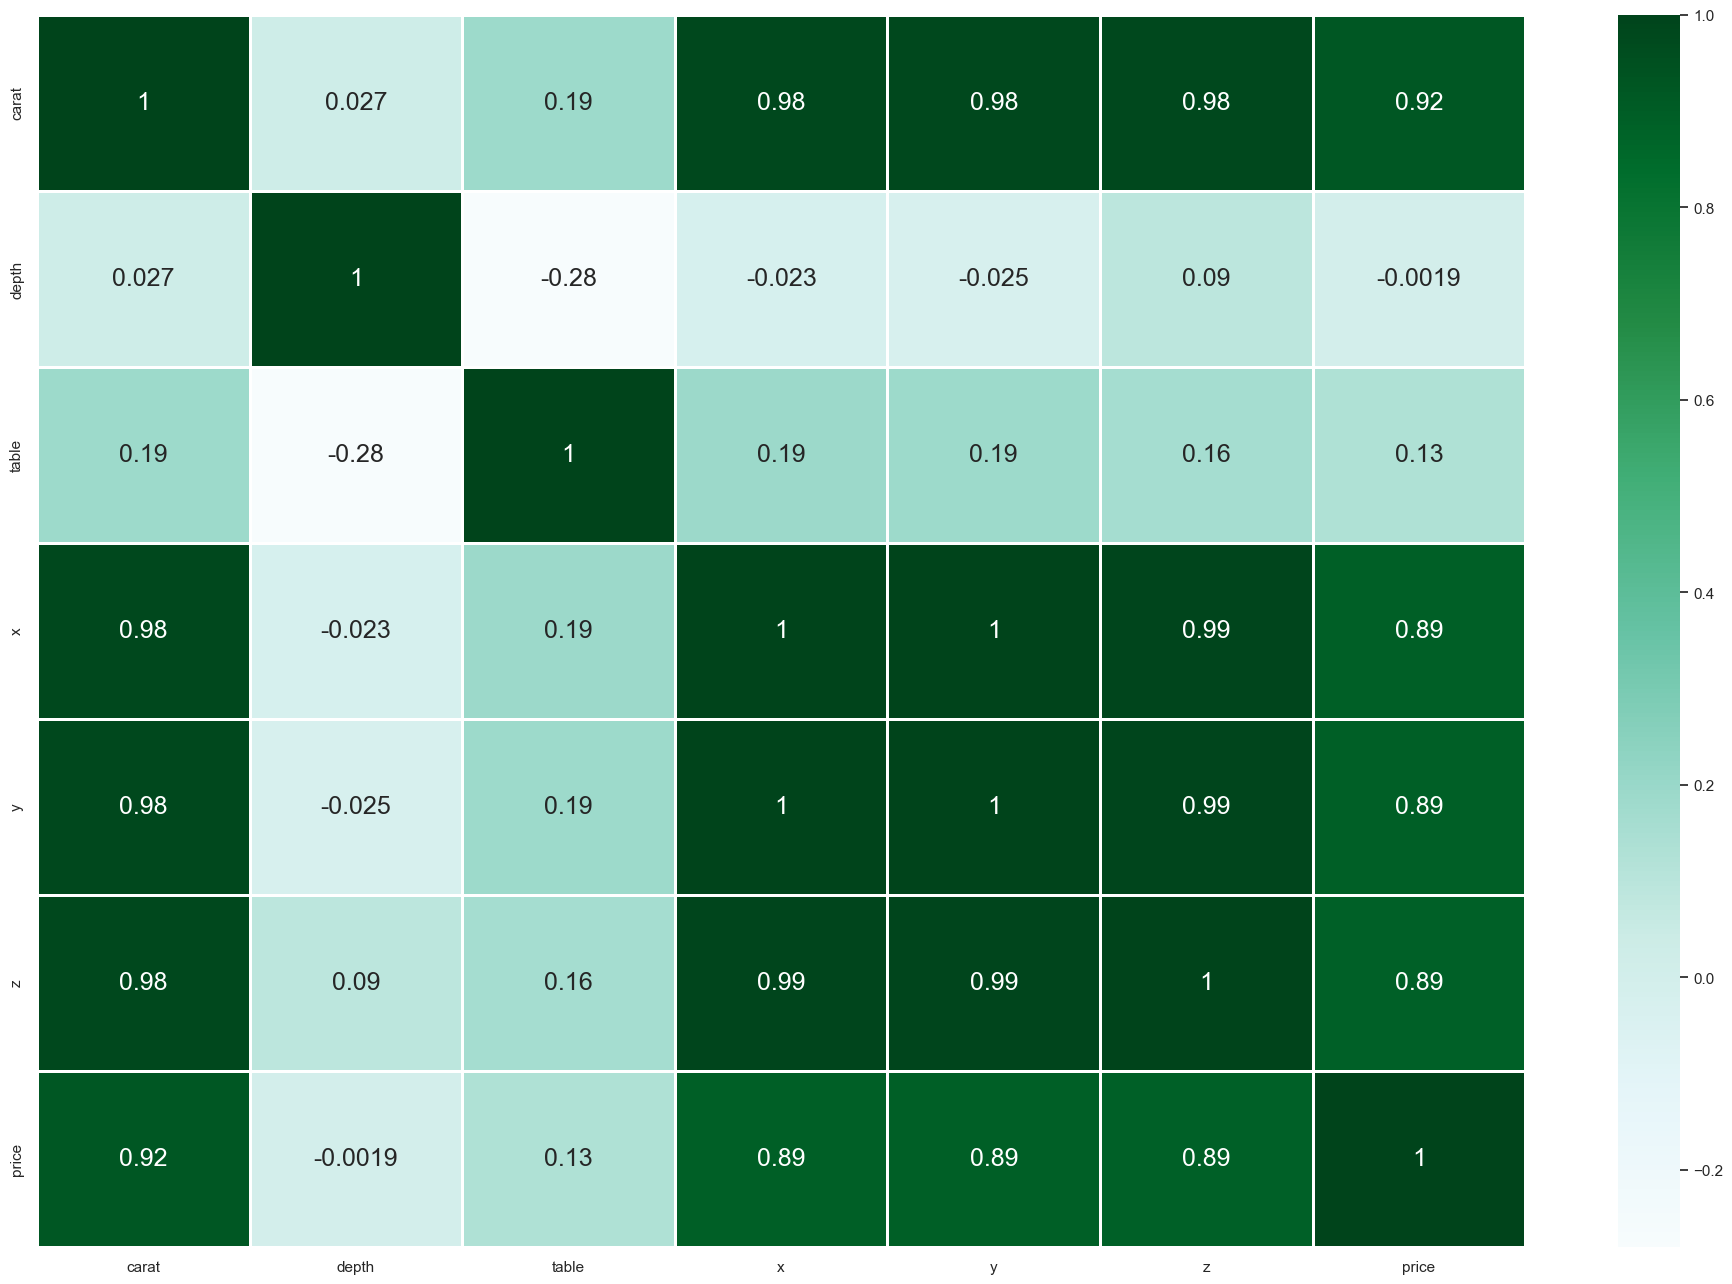

In [63]:
# Plot a correlation heatmap for quantitative measure of linear correlation
f = plt.figure(figsize=(24, 16))
sb.heatmap(data = pd.concat([numericals,pd.DataFrame(price)],axis=1).corr(), 
           linewidths = 1, annot = True, annot_kws = {"size": 18}, cmap = "BuGn")

### Depth and table have very poor linear relations with price.
### x,y,and z visually have decent linear correlations with price, and the heatmap confirms it. However, including all 3 variables will introduce multicollinearity into the model, making regression estimates unreliable. (see report for details) This makes sense from domain knowledge, hence x,y,and z will not be considered if carat is included.
### carat has the strongest linear correlation with price, which correlates well with logic.

<Axes: xlabel='table', ylabel='price'>

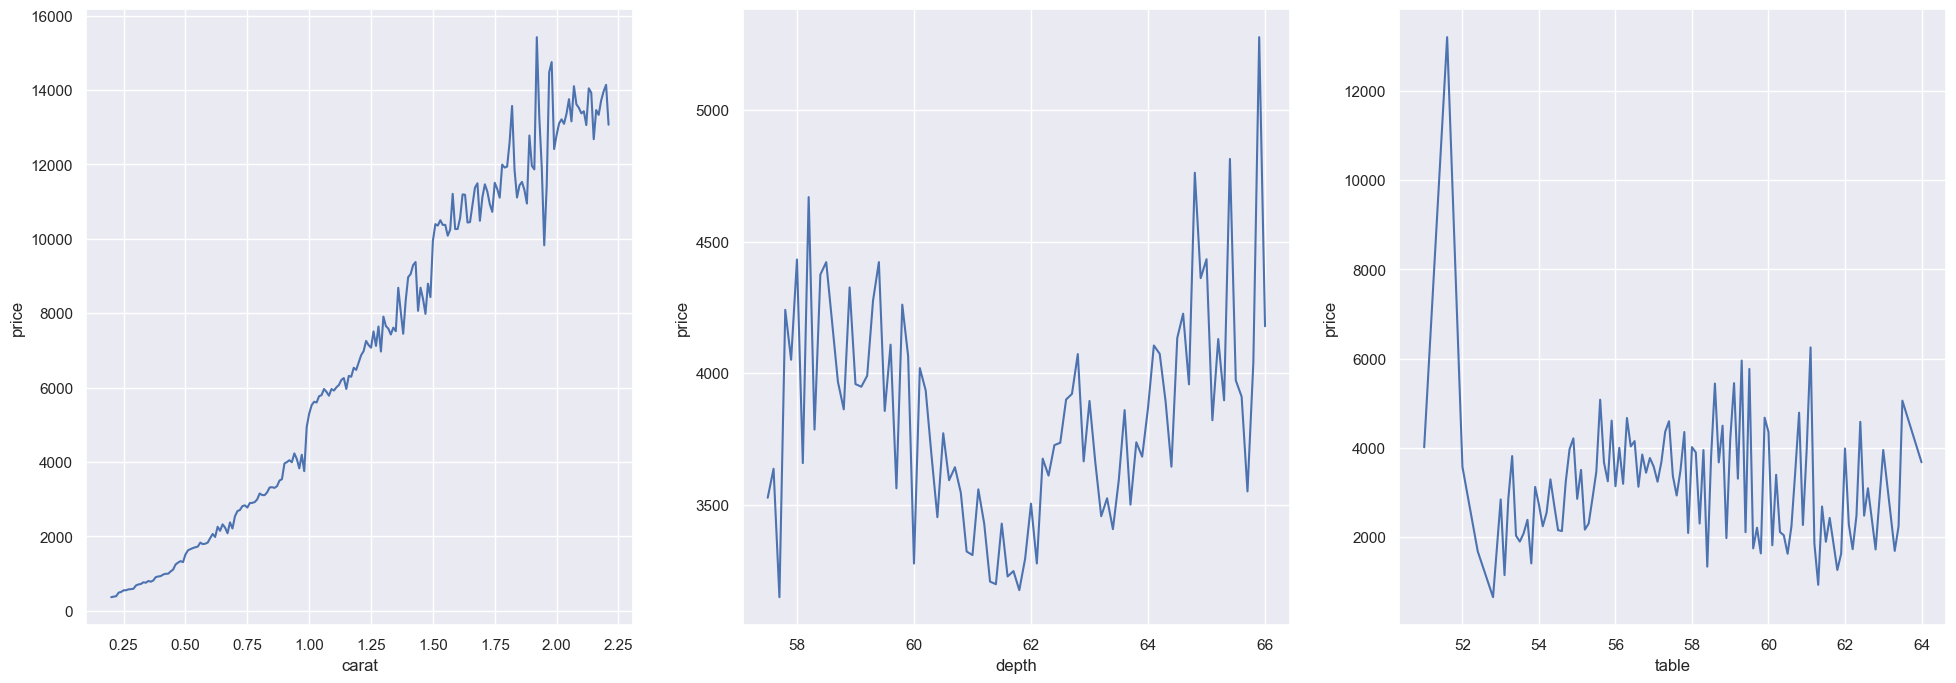

In [64]:
f, axes = plt.subplots(1,3,figsize=(24,8))

sb.lineplot(data = pd.concat([numericals,price],axis=1),x = 'carat',
            y = price,errorbar=None,ax = axes[0])
sb.lineplot(data = pd.concat([numericals,price],axis=1),x = 'depth',
            y = price,errorbar=None,ax = axes[1])
sb.lineplot(data = pd.concat([numericals,price],axis=1),x = 'table',
            y = price,errorbar=None,ax = axes[2])

### From the scatterplots, correlation heatmap and lineplots, we can safely eliminate depth and table as predictors.
### Final numerical predictors: Carat
### Final categorical predictors: clarity,color

# Variable Treatment

## Treatment of categorical variables.

<Axes: xlabel='clarity', ylabel='count'>

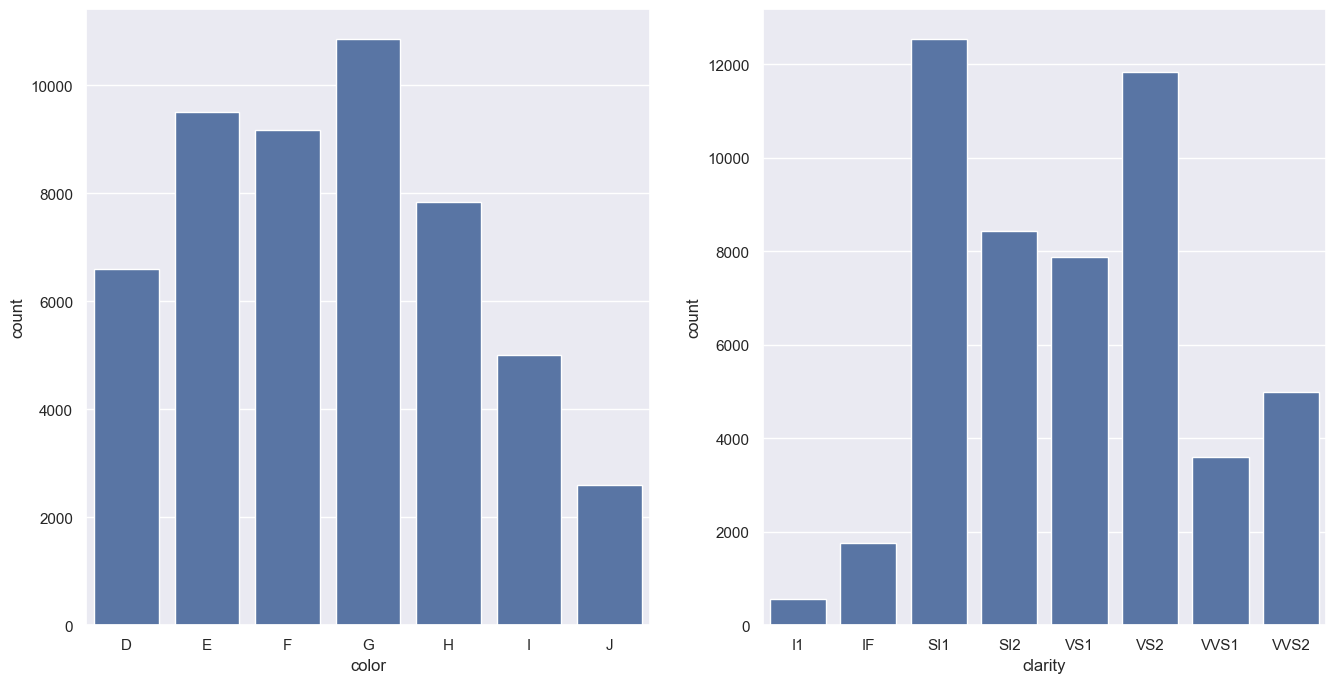

In [65]:
f, axes = plt.subplots(1,2,figsize=(16,8))
sb.countplot(data = categoricals,x = 'color',ax = axes[0])
sb.countplot(data = categoricals,x = 'clarity',ax = axes[1])

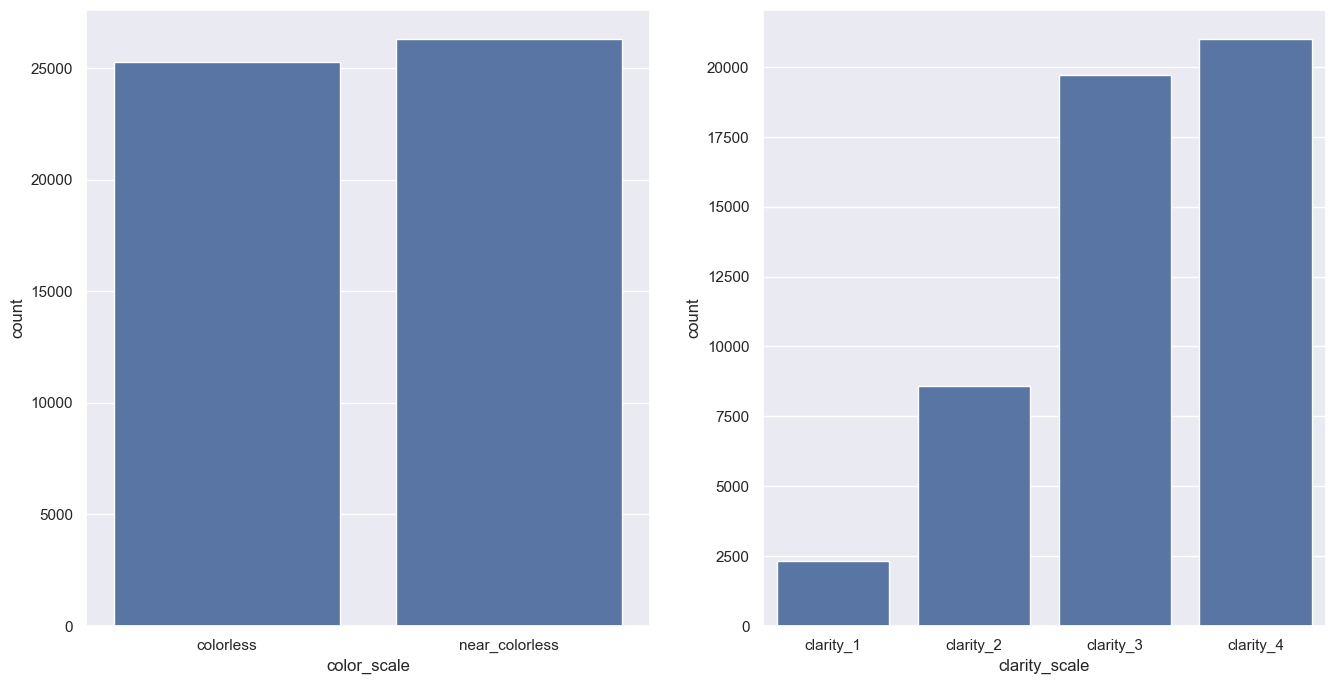

In [66]:
# Define a function to categorize the colors based on GIA scale
def categorize_color(color):
    if color in ['D', 'E', 'F']:
        return 'colorless'
    elif color in ['G', 'H', 'I', 'J']:
        return 'near_colorless'
    else:
        return 'unknown'  # Handle any other cases if needed

# Define a function to categorize the clarity based on GIA scale
def categorize_clarity(clarity):
    if clarity in ['I1', 'IF']:
        return 'clarity_1'
    elif clarity in ['VVS1', 'VVS2']:
        return 'clarity_2'
    elif clarity in ['VS1', 'VS2']:
        return 'clarity_3'
    elif clarity in ['SI1', 'SI2']:
        return 'clarity_4'
    else:
        return 'unknown'  # Handle any other cases if needed

# Apply the function to create the new column
categoricals['color_scale'] = categoricals['color'].apply(categorize_color)
categoricals['clarity_scale'] = categoricals['clarity'].apply(categorize_clarity)


f, axes = plt.subplots(1,2,figsize=(16,8))
x = 0

for cat in categoricals:
    if cat == 'clarity_scale':
        sb.countplot(data = categoricals,x = cat,ax = axes[x],
                     order=['clarity_1','clarity_2','clarity_3','clarity_4'])
        x += 1
    elif cat == 'color_scale':
        sb.countplot(data = categoricals, x = cat,ax = axes[x])
        x += 1
        
# Drop these encoded variables because encoding should only be done after dataset
categoricals = categoricals.drop(columns=['color_scale','clarity_scale'])   

### Aggregating groups within colour helps to make the data points in each new group more even. This does not work for 'clarity', thus let's drop the minority group 'clarity_1' (corresponding to I1 and IF type diamonds) from the variable during encoding. Due to the challenges stated in the report, data upsampling will not be attempted here.

## Treatment of Numerical Variables

<Axes: xlabel='carat', ylabel='price'>

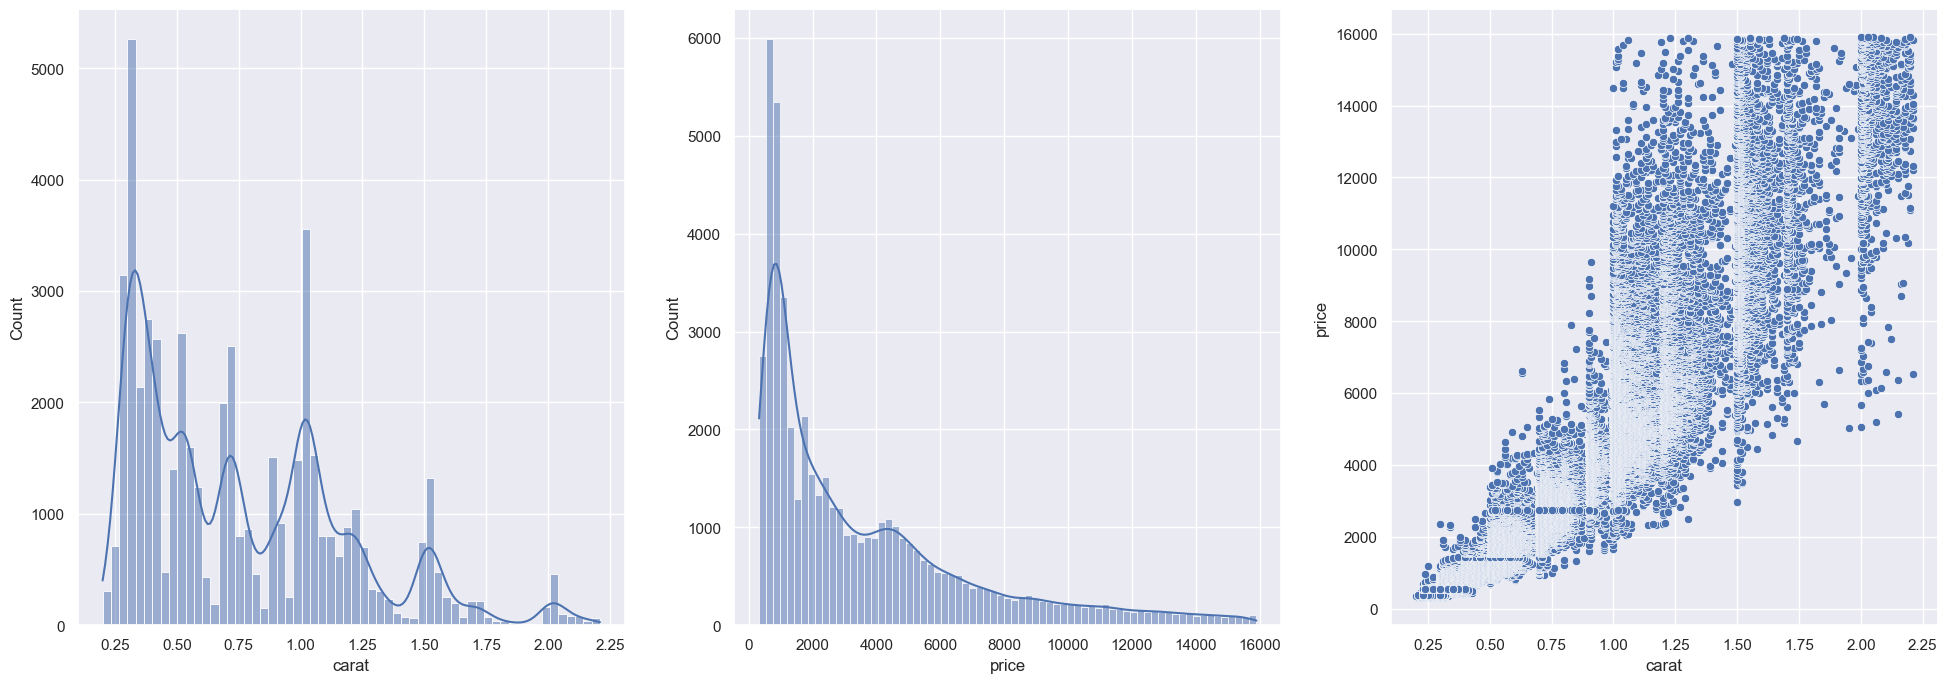

In [67]:
f, axes = plt.subplots(1,3,figsize=(24,8))
sb.histplot(data = pd.concat([numericals,price],axis=1),x = 'carat',
            ax = axes[0],kde=True)
sb.histplot(data = pd.concat([numericals,price],axis=1),x = 'price',
            ax = axes[1],kde=True)
sb.scatterplot(data = pd.concat([numericals,price],axis=1),x = 'carat',
               y = 'price')

#### As carat increases, price tends to increase. Since there are very little higher carat diamonds, it makes sense to have little higher priced diamonds in the dataset as well even after removing outliers. This uneven distribution makes sense logically, hence the distribution will not be adjusted in the model.

# Regression Model Application

## 1. Multivariate OLS

### Variables: Carat, Clarity,Colour

In [68]:
# Extract Response and Predictors
y = pd.DataFrame(price)
X = pd.concat([numericals['carat'],categoricals],axis=1)

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    random_state=42)

# Check the sample sizes
print("Train Set before grouping and encoding:", y_train.shape,
      X_train.shape)
print("Test Set  after grouping and encoding:", y_test.shape,
      X_test.shape)

# Group colour and clarity variables after dataset splitting
X_train['color_scale'] = X_train['color'].apply(categorize_color)
X_train['clarity_scale'] = X_train['clarity'].apply(categorize_clarity)
                        
X_test['color_scale'] = X_test['color'].apply(categorize_color)                            
X_test['clarity_scale'] = X_test['clarity'].apply(categorize_clarity)

# Define a dictionary with columns and their corresponding order
ordinal_encoding_color = {
    'color_scale': ['colorless','near_colorless']
}

ordinal_encoding_clarity = {
    'clarity_scale': ['clarity_1','clarity_2','clarity_3','clarity_4']
}

# Apply ordinal encoding for 'color' column in both training and testing sets
for col, order in ordinal_encoding_color.items():
    X_train[col + '_ordinal'] = X_train[col].apply(lambda x: order.index(x))
    X_test[col + '_ordinal'] = X_test[col].apply(lambda x: order.index(x))
    
# Apply ordinal encoding for 'color' column in both training and testing sets
for col, order in ordinal_encoding_clarity.items():
    X_train[col + '_ordinal'] = X_train[col].apply(lambda x: order.index(x))
    X_test[col + '_ordinal'] = X_test[col].apply(lambda x: order.index(x))

# Drop the original 'storey_range' column from both training and testing sets
X_train.drop(columns=['color','clarity','color_scale','clarity_scale'],
             inplace=True)
X_test.drop(columns=['color','clarity','color_scale','clarity_scale'],
            inplace=True)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set before grouping and encoding: (38692, 1) (38692, 3)
Test Set  after grouping and encoding: (12898, 1) (12898, 3)
Train Set : (38692, 1) (38692, 3)
Test Set  : (12898, 1) (12898, 3)


In [70]:
# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), 
             columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [-802.53536302]
Coefficients of Regression 	: a =  [[7971.79759921 -617.7386668  -629.25171928]]



,Predictors,Coefficients
0,carat,7971.797599
1,color_scale_ordinal,-617.738667
2,clarity_scale_ordinal,-629.251719


In [71]:
# Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train)  # y_hat for training
y_test_pred = linreg.predict(X_test)    # y_hat for testing

# Compute Metrics
# p: number of parameters = 4
# k: number of predictors = 3

n_obs_train = len(y_train)
y_train_average = float(y_train.mean())
 # Total Sum of Squares
S_yy_train = float(sum((np.array(y_train) - y_train_average)**2))  
# Sum of Squared Errors
SSE_train = float(sum((np.array(y_train) - y_train_pred)**2))   
# Sum of squares of the Regression
SSR_train = sum((y_train_pred-y_train_average)**2)       
       
MSE_train = SSE_train / (n_obs_train-4)
MSR_train =  SSR_train / 3


# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("R^2 Score \t:", linreg.score(X_train, y_train))
print("Adjusted R^2 Score \t:", 
      1 - (SSE_train / (n_obs_train-4)) / ((S_yy_train)/(n_obs_train-1)))
print("F Score \t:", MSR_train / MSE_train)
print("Root Mean Squared Error (RMSE) \t:", np.power(MSE_train,0.5))

Goodness of Fit of Model 	Train Dataset
R^2 Score 	: 0.8784881296034803
Adjusted R^2 Score 	: 0.8784787071569544
F Score 	: [93233.54897261]
Root Mean Squared Error (RMSE) 	: 1204.5257601498856


#### From the R2 and adjusted-R2 scores, it seems that the model has fitted well for the training dataset. Additionally, the F-scores >> f (alpha=0.05,3,n-p), where n = 38692 for training. Thus, the ANOVA test also shows that at least 1 estimator is significant in the regression model, indicating that OLS may be a good model for predicting diamond prices.

### Confidence Interval Analysis

In [72]:
import scipy.stats

#Obtain the estimated variance based on training dataset
train_variance = float(sum((np.array(y_train) - y_train_pred)**2) / (n_obs_train-4))

#Obtain the t statistic (left-tail to ensure positive)
t_stat_train = scipy.stats.t.ppf(0.975,df=n_obs_train-4)

# Calculate 95% confidence intervals for predictors: 
# carat, color_scale, clarity_scale
carat_lower = linreg.coef_[0][0] - t_stat_train*(train_variance**0.5)/(n_obs_train**0.5)
carat_higher = linreg.coef_[0][0] + t_stat_train*(train_variance**0.5)/(n_obs_train**0.5)

color_scale_lower = linreg.coef_[0][1] - t_stat_train*(train_variance**0.5)/(n_obs_train**0.5)
color_scale_higher = linreg.coef_[0][1] + t_stat_train*(train_variance**0.5)/(n_obs_train**0.5)

clarity_scale_lower = linreg.coef_[0][2] - t_stat_train*(train_variance**0.5)/(n_obs_train**0.5)
clarity_scale_higher = linreg.coef_[0][2] + t_stat_train*(train_variance**0.5)/(n_obs_train**0.5)

OLS_CI_data = pd.DataFrame(
    columns = ['Variables','Estimator Values','95% CI lowerB','95% CI UpperB']
    )
OLS_CI_data['Variables'] = ['Carat','Color_scale','Clarity_scale']
OLS_CI_data['Estimator Values'] = linreg.coef_[0]
OLS_CI_data['95% CI lowerB'] = [carat_lower,color_scale_lower,
                                clarity_scale_lower]
OLS_CI_data['95% CI UpperB'] = [carat_higher,color_scale_higher,
                                clarity_scale_higher]
OLS_CI_data.head()

,Variables,Estimator Values,95% CI lowerB,95% CI UpperB
0,Carat,7971.797599,7959.795224,7983.799974
1,Color_scale,-617.738667,-629.741042,-605.736292
2,Clarity_scale,-629.251719,-641.254094,-617.249345


### Residual Analysis for Multivariate OLS

Text(0, 0.5, 'Residuals from OLS')

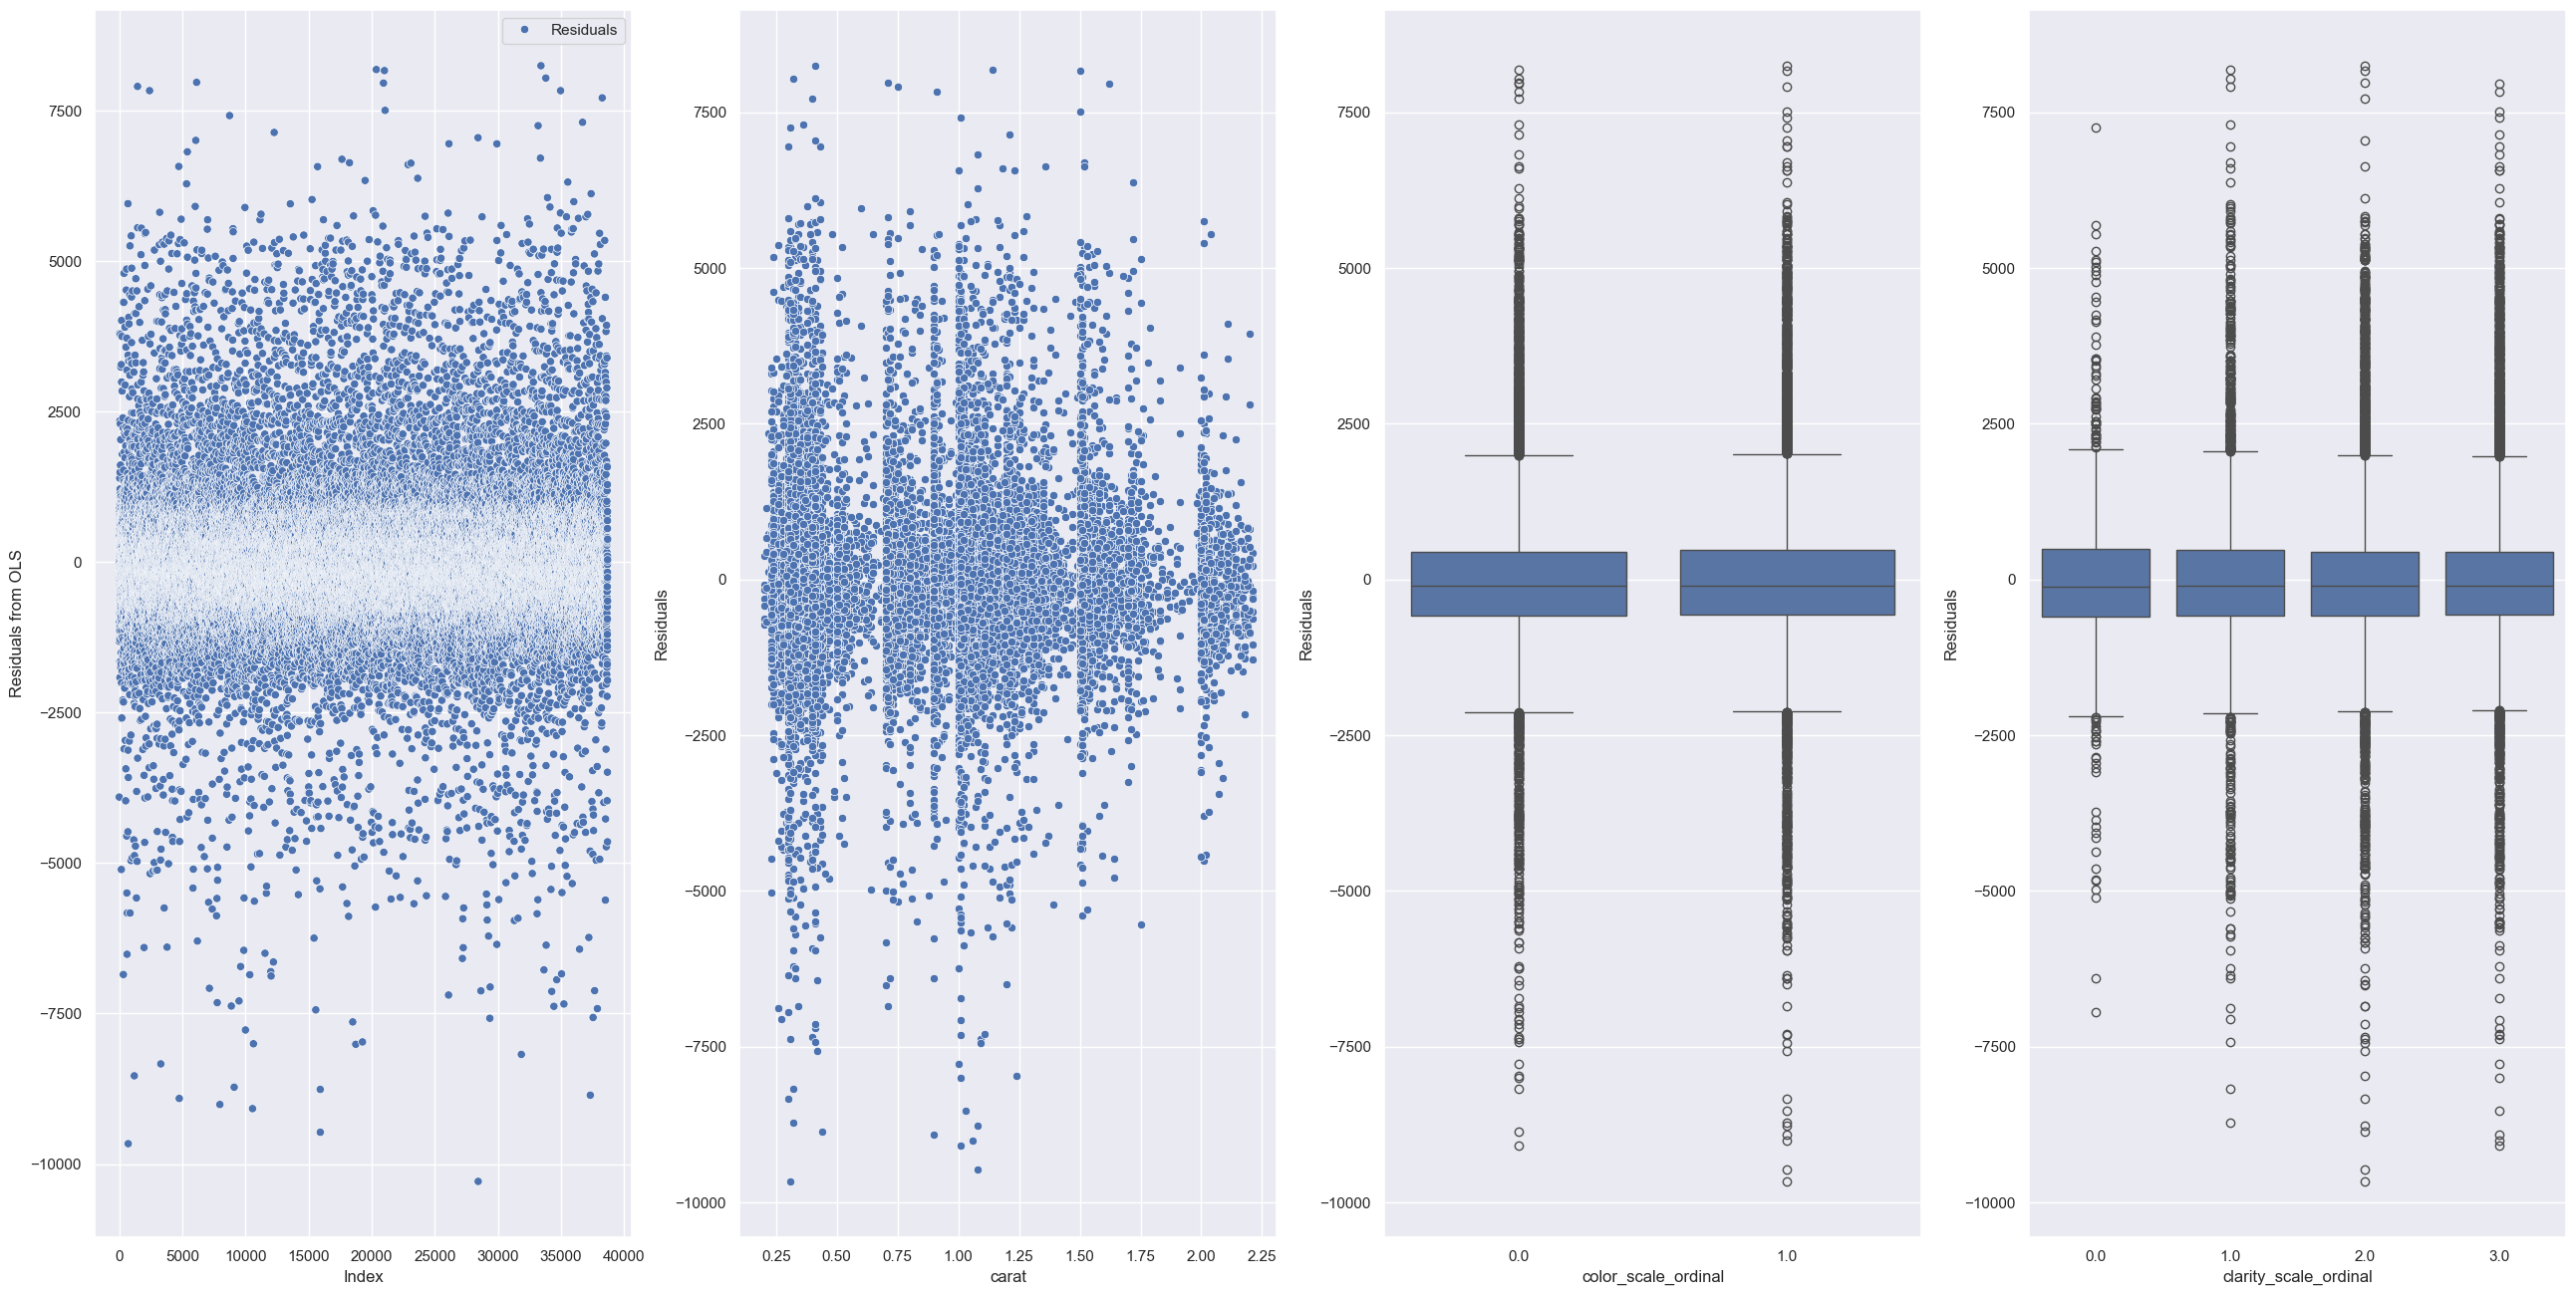

In [73]:
residuals_OLS = pd.DataFrame((np.array(y_train) - y_train_pred),
                             columns=['Residuals'])

f,axes = plt.subplots(1,4,figsize=(32,16))
ax = sb.scatterplot(data = residuals_OLS,ax = axes[0])
ax1 = sb.scatterplot(data = pd.concat([residuals_OLS,X_train],axis=1),
                     x = 'carat',y = 'Residuals',ax = axes[1])
ax2 = sb.boxplot(data = pd.concat([residuals_OLS,X_train],axis=1),
                 x = 'color_scale_ordinal',y = 'Residuals',ax = axes[2])
ax3 = sb.boxplot(data = pd.concat([residuals_OLS,X_train],axis=1),
                 x = 'clarity_scale_ordinal',y = 'Residuals',ax = axes[3])
ax.set_xlabel("Index")
ax.set_ylabel("Residuals from OLS")

Residuals    3.760962e-14
dtype: float64


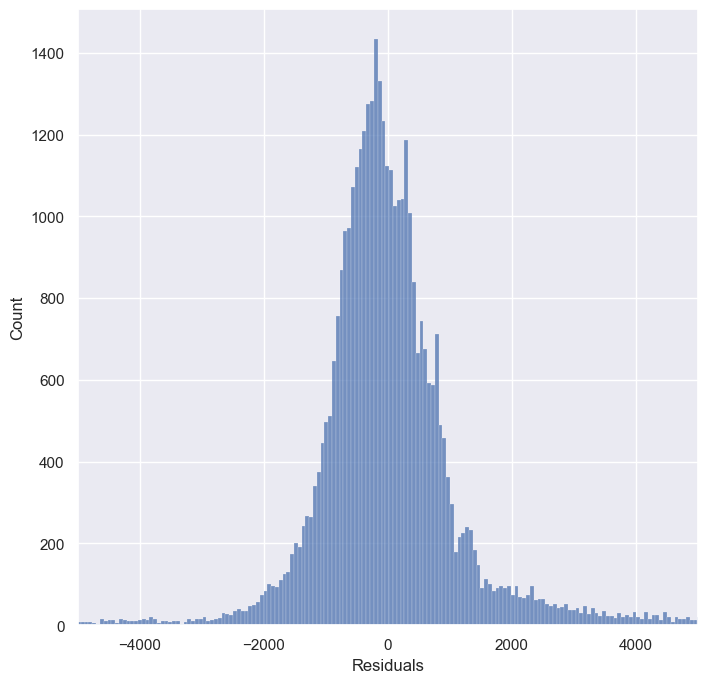

In [74]:
f = plt.figure(figsize=(8,8))
ax = sb.histplot(data = residuals_OLS, x = 'Residuals')
ax.set_xlim(-5000,5000)
print(residuals_OLS.mean())

#### Residuals do not seem to have a relationship between the regressors, hence OLS modelling may be suitable. More details in report.

### Cross-Validation with validation dataset

In [75]:
n_obs_test = float(len(X_test))
y_test_average = float(y_test.mean())
 # Total Sum of Squares
S_yy_test = float(sum((np.array(y_test) - y_test_average)**2))  
# Sum of Squared Errors
SSE_test = float(sum((np.array(y_test) - y_test_pred)**2))   
 # Sum of squares of the Regression
SSR_test = sum((y_test_pred-y_test_average)**2)
             
MSE_test = SSE_test / (n_obs_test-4)
MSR_test =  SSR_test / 3

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("R^2 Score \t:", linreg.score(X_test, y_test))
print("Adjusted R^2 Score \t:", 1 - (SSE_test / (n_obs_test-4)) / ((S_yy_test)/(n_obs_test-1)))
print("Root Mean Squared Error (RMSE) \t:", np.power(MSE_test,0.5))

Goodness of Fit of Model 	Test Dataset
R^2 Score 	: 0.8766677172442389
Adjusted R^2 Score 	: 0.8766390219713781
Root Mean Squared Error (RMSE) 	: 1187.2914454600432


#### Cross-validation regression metrics seems to imply that model can generalise well to unseen data. This implies that multivariate OLS can be a good model to predict diamond prices

## 2. Ridge Regression (No longer considered, not covered in report)

### Variables: Carat, clarity, colour

#### We can utilise the same training and testing datasets, X_train and X_test, created earlier.

#### Firstly, we utilise the training dataset to determine the optimal regulatization parameter, alpha

<Axes: xlabel='Alpha', ylabel='RMSE'>

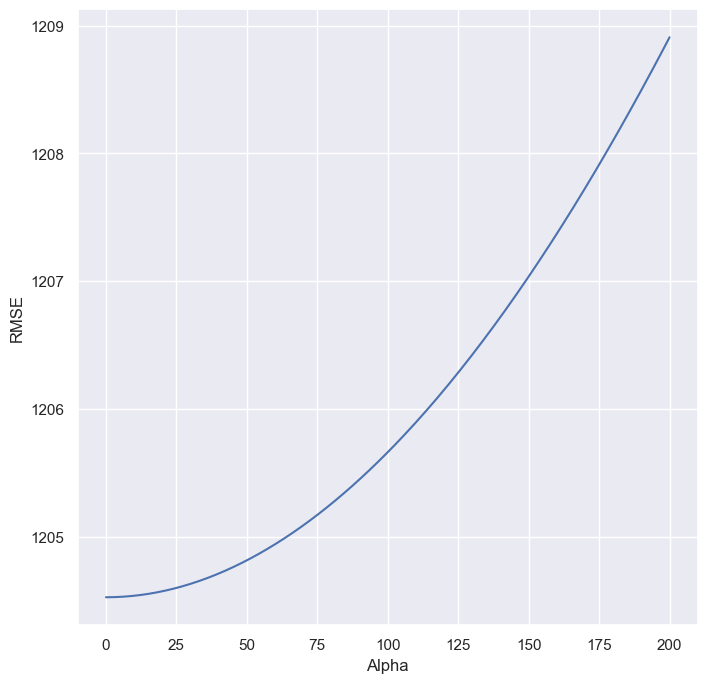

In [76]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, root_mean_squared_error


Ridge_RMSE = []
for alpha in np.linspace(0,200,num=200):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train,y_train)
    y_hat = ridge.predict(X_train)
    n = float(len(X_train))
    rmse = float(np.power(sum((np.array(y_train) - y_hat)**2) / (n - 4),0.5))
    Ridge_RMSE.append(rmse)

Ridge_data = pd.DataFrame(columns = ['Alpha','RMSE'])
Ridge_data['Alpha'] = np.linspace(0,200,num=200)
Ridge_data['RMSE'] = Ridge_RMSE

f = plt.figure(figsize=(8,8))
sb.lineplot(data = Ridge_data,x = 'Alpha',y = 'RMSE')

#### From the results of obtaining an optimal alpha, it seems that optimal alpha = 0, which reduces ridge regression to the original OLS model. Thus, Ridge regression may not be an ideal model for this dataset, and would be better off sticking to the OLS model.

## 3. Random Forest Regression

<Axes: xlabel='Depth', ylabel='RMSE'>

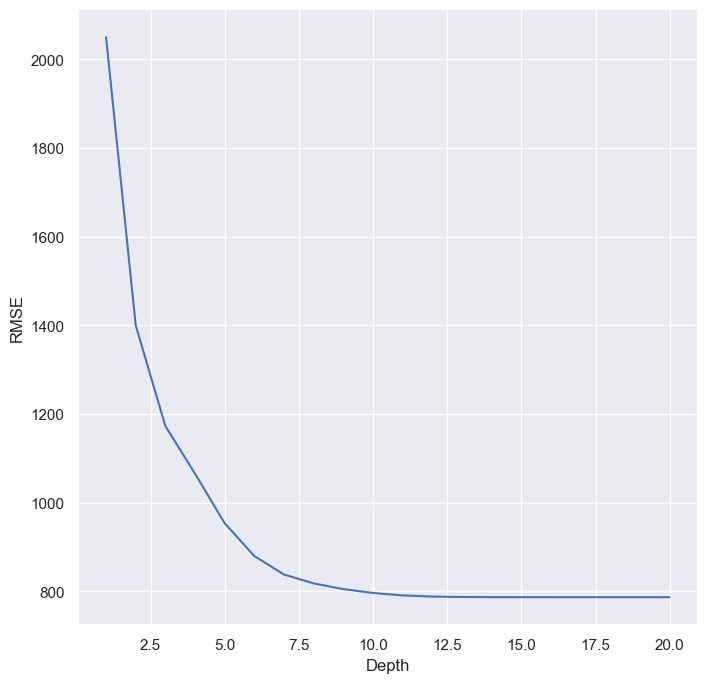

In [77]:
from sklearn.ensemble import RandomForestRegressor

RF_RMSE = []
for depth in np.linspace(1,20,num=20):
    depth = int(depth)
    random_fr = RandomForestRegressor(max_depth=depth,random_state=42)
    random_fr.fit(X_train,y_train)
    y_hat = random_fr.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train,y_hat))
    RF_RMSE.append(rmse)

RF_data = pd.DataFrame(columns = ['Depth','RMSE'])
RF_data['Depth'] = np.linspace(1,20,num=20)
RF_data['RMSE'] = RF_RMSE

f = plt.figure(figsize=(8,8))
sb.lineplot(data = RF_data,x = 'Depth',y = 'RMSE')

<Axes: xlabel='n_estimators', ylabel='RMSE'>

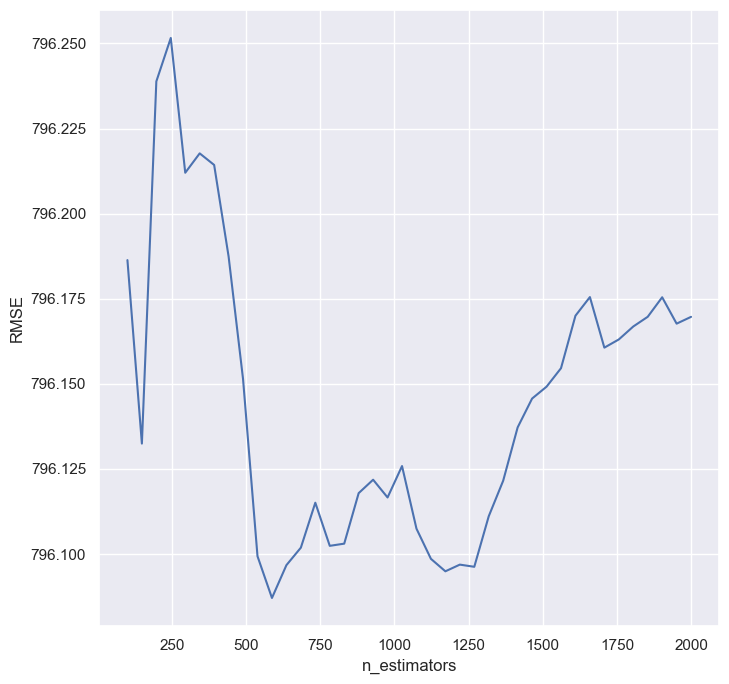

In [78]:
# Optimise RF based on n_estimators at depth = 10
RF_RMSE = []
for estimators in np.linspace(100,2000,num=40):
    estimators = int(estimators)
    random_fr = RandomForestRegressor(n_estimators = estimators,
                                      max_depth=10,random_state=42)
    random_fr.fit(X_train,y_train)
    y_hat = random_fr.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train,y_hat))
    RF_RMSE.append(rmse)

RF_data = pd.DataFrame(columns = ['n_estimators','RMSE'])
RF_data['n_estimators'] = np.linspace(100,2000,num=40)
RF_data['RMSE'] = RF_RMSE

f = plt.figure(figsize=(8,8))
sb.lineplot(data = RF_data,x = 'n_estimators',y = 'RMSE')

#### The trend of RMSE against n_estimators is quite erratic, however there is a minimum RMSE value visible. Let's take that as the optimal n_estimator parameter for now.

In [79]:
min_rmse_index = RF_data['RMSE'].idxmin()
optimal_estimators = RF_data.loc[min_rmse_index, 'n_estimators']
print(optimal_estimators)

587.1794871794872


#### From the above optimisation instance, the optimal tree depth = 10 and n_estimators (number of trees in 1 forest) = 587 approx. Let's begin training the model.

In [80]:
RF = RandomForestRegressor(n_estimators = 587,max_depth=10,
                           random_state=42)
RF.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=587, random_state=42)

In [81]:
n_obs_train = len(X_train)
y_train_pred_rf = RF.predict(X_train)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("R^2 Score \t:", RF.score(X_train, y_train))
print("Root Mean Squared Error (RMSE) \t:", root_mean_squared_error(y_train, y_train_pred_rf))

Goodness of Fit of Model 	Train Dataset
R^2 Score 	: 0.946917349946713
Root Mean Squared Error (RMSE) 	: 796.0871016436174


In [82]:
# Assuming rf_model is your trained Random Forest model
feature_importances = RF.feature_importances_

# Print feature importances
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"Feature {i}: {importance}")

Feature Importances:
Feature 0: 0.9280655435869722
Feature 1: 0.016649445786388887
Feature 2: 0.05528501062663896


In [83]:
y_test_pred_rf = RF.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("R^2 Score \t:", RF.score(X_test, y_test))
print("Root Mean Squared Error (RMSE) \t:", root_mean_squared_error(y_test, y_test_pred_rf))

Goodness of Fit of Model 	Train Dataset
R^2 Score 	: 0.9398324333069368
Root Mean Squared Error (RMSE) 	: 829.149464096264
